# Hubbard Model Example

Here, we will use the **PyMPS** tool to find the ground state of a simple Hubbard model given by the following Hamiltonian

$$
H = \sum_{i=1}^N U n_{i\uparrow}n_{i\downarrow} + \sum_{i=1}^{N-1} \sum_{\sigma\in \{ \uparrow, \downarrow \} } t c^+_{i,\sigma}c_{i+1,\sigma} + \textrm{h.c.} + \mu \sum_{i,\sigma} n_{i,\sigma}
$$

This Hamiltonian describes a chain of $N$ single orbital atoms, where $U$ is the energy for an $\uparrow$ and a $\downarrow$ electron to occupy an atom, $t$ is the energy for an electron to tunnel from one atom to another and $\mu$ is the chemical potential.

First, let's import the **PyMPS** tool

In [17]:
import sys
sys.path.append('../')
import pymps as mp


Let us define our fermionic operators. We can do this with the fermion operator class which defines a fermionic operator by its orbital number and the total number of orbitals $L$ our system has. We do this with the following code
```
mp.FermiOp(i,L,1) # the last index 1 indicates that this is a creation operator

mp.FermiOp(i,L,0) # 0 indicates an annihilation operator
```

With these operators, we can define other operators like the number operator $n_{i\uparrow}$. We define the following operators for the Hubbard model below.

In [18]:
def C_dag(i):
    return mp.FermiOp(i,L,1)
def C(i):
    return mp.FermiOp(i,L,0) 

def N(i):
    return C_dag(i)*C(i)

Since each atom has two indices, let's define a function to convert the double index into a single one.

In [19]:
def ix(dot,spin):
    """
    Converts indices to a single index

    Parameters
    ----------
    dot : int
        Dot number
    spin : int
        0 for spin down, 1 for spin up.

    Returns
    -------
    int

    """
    return 2*dot+spin

Using these operators we have defined, let's create the Hamiltonian. First, we define a **matrix product operator** (MPO) for the Hamiltonian with the ``mp.QuantumOperator(L)`` class.

Now we can construct our Hamiltonian in a way that resembles how it looks written on paper. Let's do an example using 10 atoms, $U=10$, $t=1$ and $\mu=10$.

In [27]:
n_sites = 10
L = 2*n_sites #Here we define system size

#Hubbard Parameters
U=20
t = 1.0
chem_pot = 10.

H = mp.QuantumOperator(L)

#=============================================================================

for i in range(n_sites):
        H.add(N(ix(i,1))*N(ix(i,0))*U) #Hubbard term

for i in range(n_sites):
    for alpha in range(2):
        for spin in range(2):
            H.add(C_dag(ix(i,spin))*C(ix(i+1,spin))*(t))
            H.add(C_dag(ix(i+1,spin))*C(ix(i,spin))*(t)) #Tunneling term

for i in range(L):
   H.add(N(i)*(-chem_pot)) #Chemical potential term

#============================================================================

MPO, MPO_edges = H.GetMPOTensors() #This converts the Hamiltonian into an MPO

With the Hamiltonian stored as an MPO, we can use the MPS-DMRG algorithm to find the ground state. For this example, we will use a bond dimension of 20 and use 4 sweeps. 

In [72]:
bonddim = 20
nsweeps = 4

mps = mp.init_wavefunction(L, bonddim) #Initial guess for wavefunction

energy, MPS = mp.DMRG(L, MPO, nsweeps, mps)

print("Ground state energy = ",energy)
print("Done!")

Sweep Number: 0 

Lanczos failed, residual norm = [6.4089715e-10]
site 0:   Energy=[-66.06901854]

Lanczos failed, residual norm = [6.47502899e-05]
site 1:   Energy=[-68.48987013]

Lanczos failed, residual norm = [0.0005751]
site 2:   Energy=[-71.35542573]

Lanczos failed, residual norm = [0.00176794]
site 3:   Energy=[-74.2244787]

Lanczos failed, residual norm = [0.02835801]
site 4:   Energy=[-77.65988222]

Lanczos failed, residual norm = [0.03202974]
site 5:   Energy=[-79.7511253]

Lanczos failed, residual norm = [0.00082946]
site 6:   Energy=[-81.7856104]

Lanczos failed, residual norm = [0.00697919]
site 7:   Energy=[-85.47972972]

Lanczos failed, residual norm = [0.00171817]
site 8:   Energy=[-88.2651132]

Lanczos failed, residual norm = [0.0114362]
site 9:   Energy=[-90.86806109]

Lanczos failed, residual norm = [0.0064355]
site 10:   Energy=[-93.6858682]

Lanczos failed, residual norm = [0.01174432]
site 11:   Energy=[-96.29862994]

Lanczos failed, residual norm = [0.00969285]


Now that we have the wavefunction $|\Psi\rangle$ as an MPS, we can compute expectation values of any observable we want. 

Let's compute the total number of electrons $\langle n_{\textrm{Tot}} \rangle$ and the total $z$-component of spin $\langle S_{\textrm{Tot}}^z \rangle$

In [73]:
"""
Defining number operator for expectation value
"""
n = mp.QuantumOperator(L)
for i in range(L):
   n.add(N(i))
number_e = n.ExpectatioValue(MPS)

"""
Compute S^z
"""
Sz = mp.QuantumOperator(L)

for i in range(n_sites):
        for j in range(n_sites):
            Sz.add(N(ix(i,1))*(0.5)) #Sz
            Sz.add(N(ix(i,0))*(-0.5)) #Sz
Stotz = Sz.ExpectatioValue(MPS)

print("Number of particles = {}".format(round(number_e)),'Sz={:.4f}'.format(Stotz))

Number of particles = 10 Sz=0.0009


To show the true power of MPS-DMRG, we will generate random MPSs and plot the number of configurations as a function of system size $N$ and compare this with the number of configurations using exact diagonalization. 

The exact diagonalization complexity for a given system size of $N$ atoms is given by

$$
\binom{\textrm{Number of states}}{\textrm{Number of electrons}}=\binom{2\times N}{N} .
$$



We will show that the complexity grows *exponentially* with respect to system size for exact diagonalization, while it grows *linearly* for MPS-DMRG.

N_atoms  MPS Complexity  Exact Diagonalization Complexity
2            472            6.0
3            2840            20.0
4            6040            70.0
5            9240            252.0
6            12440            924.0
7            15640            3432.0
8            18840            12870.0
9            22040            48620.0
10            25240            184756.0
11            28440            705432.0
12            31640            2704156.0
13            34840            10400600.0
14            38040            40116600.0
15            41240            155117520.0
16            44440            601080390.0
17            47640            2333606220.0
18            50840            9075135300.0
19            54040            35345263799.99999


Text(0, 0.5, 'Number of electron configurations')

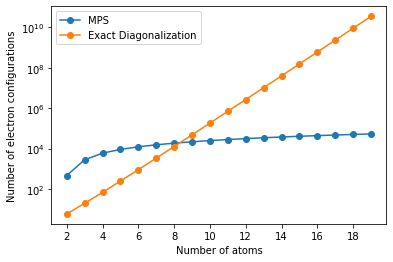

In [101]:
import scipy.special as sp

n_tot_sites=20

x = []
n_conf_mps = []

n_conf_ed = []

print("N_atoms  MPS Complexity  Exact Diagonalization Complexity")
print("=========================================================")
for k in range(2,n_tot_sites):
    mps_complexity = 0
    for spin in range(2):
        MPS = mp.init_wavefunction(ix(k,spin), bonddim)

        mps_complexity += np.sum([np.prod([np.shape(MPS[i].tensor)]) for i in range(len(MPS))])

    x.append(k)
    n_conf_mps.append(mps_complexity)
    
    ed_complexity = sp.binom(k*2,k)
    n_conf_ed.append(ed_complexity)
    print(k,"          ",mps_complexity,"          ",ed_complexity)
    
    

import matplotlib.pyplot as plt

plt.yscale("log")
plt.xticks(np.arange(2, n_tot_sites, step=2))


plt.plot(x,n_conf_mps,'o',ls='-',label='MPS')
plt.plot(x,n_conf_ed,'o',ls='-',label='Exact Diagonalization')

plt.legend()
plt.xlabel("Number of atoms")
plt.ylabel("Number of electron configurations")